In [1]:
#импортируем нужные библиотеки
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#объявляем параметры подключения
connection = dict(database='default',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student',
                  password='dpo_python_2020')

In [3]:
# сколько строк ldn_listings
# пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT count(*)
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection)
df

,count()
0,85207


In [4]:
# 2-3 Выгрузить по типу жилья
query = """
SELECT  room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price  
FROM ldn_listings
ORDER BY id
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [5]:
df.query('room_type=="Private room"').price.quantile(q=0.75)

70.0

In [6]:
# 2-4 выгрузите данные о рейтинге жилья
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
       toFloat32OrNull(review_scores_rating) AS scores
FROM ldn_listings
WHERE scores is not null
ORDER BY id
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price,scores
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [7]:
a=df.groupby('room_type',as_index=False).agg({'price':'mean', 'scores':'mean'})

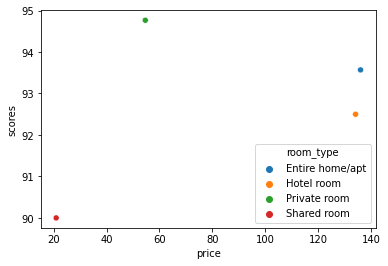

In [8]:
# построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья
sns.scatterplot(x=a.price,y=a.scores,hue=a.room_type)

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [9]:
# 2-5 
query = """
SELECT distinct host_id, host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
df

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [10]:
df['host_verifications']=df.host_verifications\
                        .apply(lambda x: str(x).strip().replace('[','').replace(']','').replace(",","").split())
df

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [11]:
count_explode=df.host_verifications.explode().value_counts()

In [12]:
count_explode

'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
Name: host_verifications, dtype: int64

In [13]:
# 2-6 Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления.
query = """
SELECT neighbourhood_cleansed, experiences_offered, count(experiences_offered) as experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed,experiences_offered
ORDER BY experiences_count desc
LIMIT 100
"""
df = ph.read_clickhouse(query, connection=connection)
df

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


Преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap()

In [14]:
c=df.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

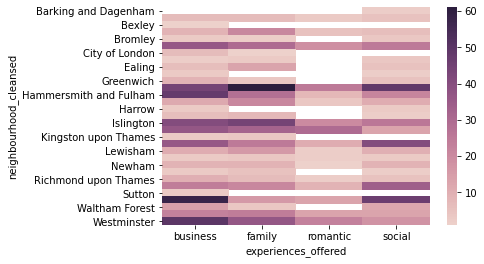

In [15]:
sns.heatmap(c,cmap=sns.cubehelix_palette(as_cmap=True))

In [16]:
# 2-7 Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.
query = """
SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


Далее постройте два графика, используя distplot из библиотеки seaborn:

1. На первом отобразите исходные распределения цен для каждого типа жилья
2. На втором – логарифмированные значения (np.log())

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


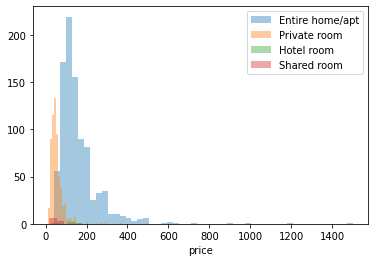

In [17]:
sns.distplot(df.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type== 'Private room'").price, kde=False, label='Private room')
sns.distplot(df.query("room_type== 'Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df.query("room_type== 'Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

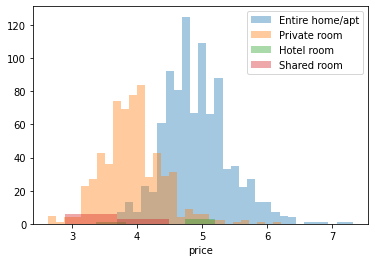

In [18]:
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type== 'Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type== 'Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df.query("room_type== 'Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

In [19]:
# 2-8 Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.
query = """
SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price, first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [20]:
df['first_review']=df.first_review.apply(lambda x: x[0:4])

In [21]:
df.sort_values('first_review')

,room_type,price,first_review
0,Private room,65.0,2010
44,Private room,55.0,2010
39,Private room,75.0,2010
38,Entire home/apt,78.0,2010
33,Private room,45.0,2010
...,...,...,...
887,Private room,21.0,2019
277,Private room,105.0,2019
431,Private room,35.0,2019
12,Private room,39.0,2020


Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

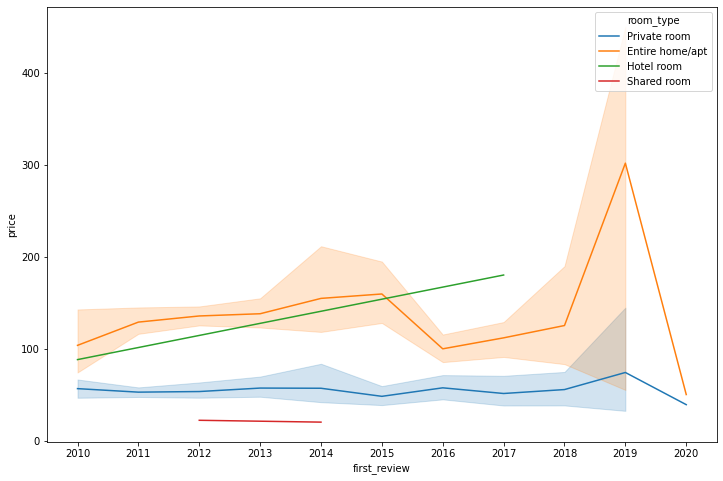

In [22]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price',hue='room_type',data=df.sort_values('first_review'))